```bash 
conda install -c anaconda py-xgboost

conda install -c conda-forge lightgbm
```

I think the following code finally allowed me to install xgboost.


# Competition Winning Algorithms: CatBoost vs. Light GBM vs. XGBoost

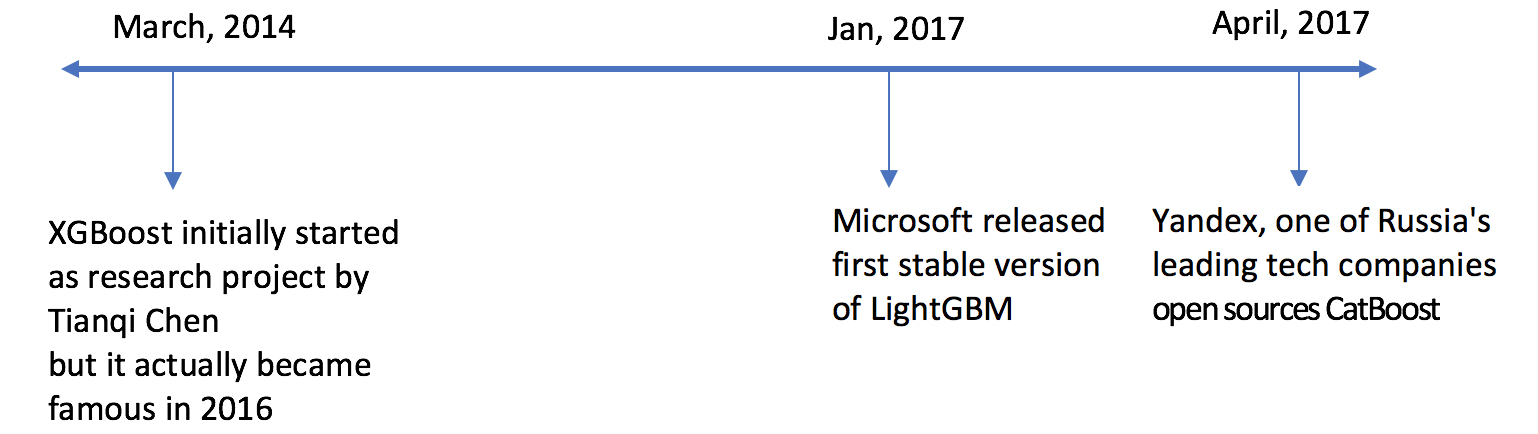

## 0. Resources:

### Compiled from:

https://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/

https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb

https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d

https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909

https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/

### Original papers:

Xgboost: https://arxiv.org/pdf/1603.02754.pdf

Lightgbm: https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf

Catboost: http://learningsys.org/nips17/assets/papers/paper_11.pdf


### Documentations:

Xgboost: https://xgboost.readthedocs.io/en/latest/

Lightgbm: https://lightgbm.readthedocs.io/en/latest/index.html

Catboost: https://catboost.ai/docs/concepts/about.html


##  <span style="color:red"> Purpose of this notebook: </span>
> ###  <span style="color:red">High-level understanding of these algorithms and how to use them</span>

## 1. Review of Decision Tree

Traditional decision tree algorithm tries to split data by finding out the feature and feature value that has the most information gain. This is known as **pre-sorting** algorithm.

### 1.1 How pre-sorting splitting works
+ For each node, enumerate over all features
+ For each feature, sort the instances by feature value
+ Use a linear scan to decide the best split along that feature basis information gain
+ Take the best split solution along all the features

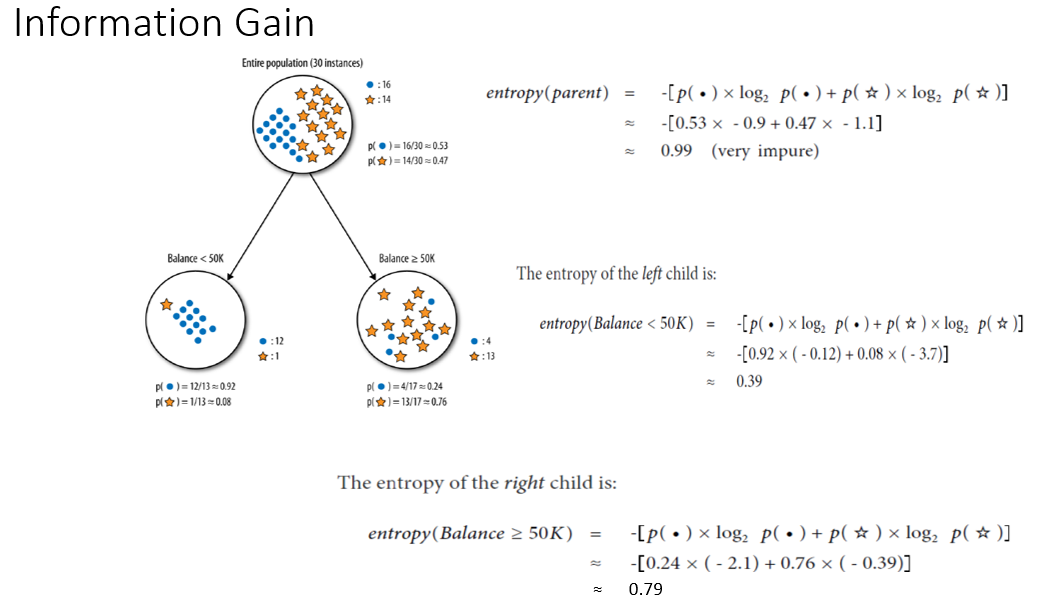

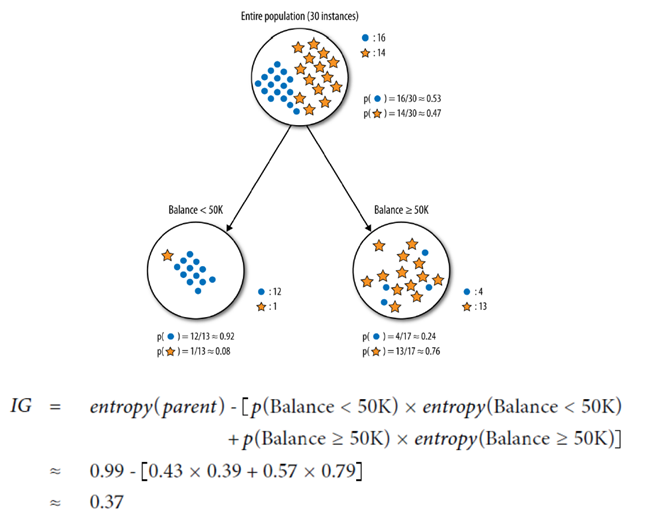

### 1.2 Histogram-based algorithm spliting
The difference from pre-sorting is that it splits all the data points for a feature into discrete bins (instead of trying all values) and uses these bins to find the split value of histogram.

> ### What is the improvement?


> ### Problem with pre-sorting and histogram-based algorithms?


> #### XgBoost uses both pre-sorting and histogram-based algorithms.

### 1.3 Gradient-based One-Side Sampling (GOSS)
**Lightgbm uses GOSSS.**

Gradient represents the slope of the tangent of the loss function, so logically if gradient of data points are large in some sense, these points are important for finding the optimal split point as they have higher error.

GOSS **keeps all the instances with large gradients** and performs **random sampling on the instances with small gradients.** For example, let’s say I have 500K rows of data where 10k rows have higher gradients. So my algorithm will choose (10k rows of higher gradient+ x% of remaining 490k rows chosen randomly). Assuming x is 10%, total rows selected are 59k out of 500K on the basis of which split value if found.

### 1.4 Tree Growing Strategies

There are two different strategies to compute the trees: level-wise and leaf-wise. 

The level-wise strategy grows the tree level by level. In this strategy, each node splits the data prioritizing the nodes closer to the tree root. 

The leaf-wise strategy grows the tree by splitting the data at the nodes with the highest loss change. 

Level-wise growth is usually better for smaller datasets whereas leaf-wise tends to overfit. 

Leaf-wise growth tends to excel in larger datasets where it is considerably faster than level-wise growth.

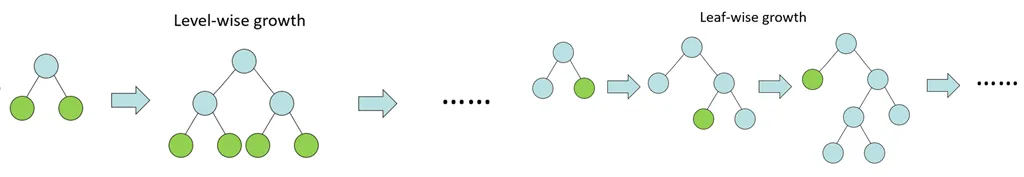

Originally XGBoost was based on a level-wise growth algorithm, but recently has added an option for leaf-wise growth that implements split approximation using histograms. 

LightGBM is based on a leaf-wise algorithm and histogram approximation.

### 1.5 How each model treats Categorical Variables?

**Label encoding** assigns each unique value to a different integer.

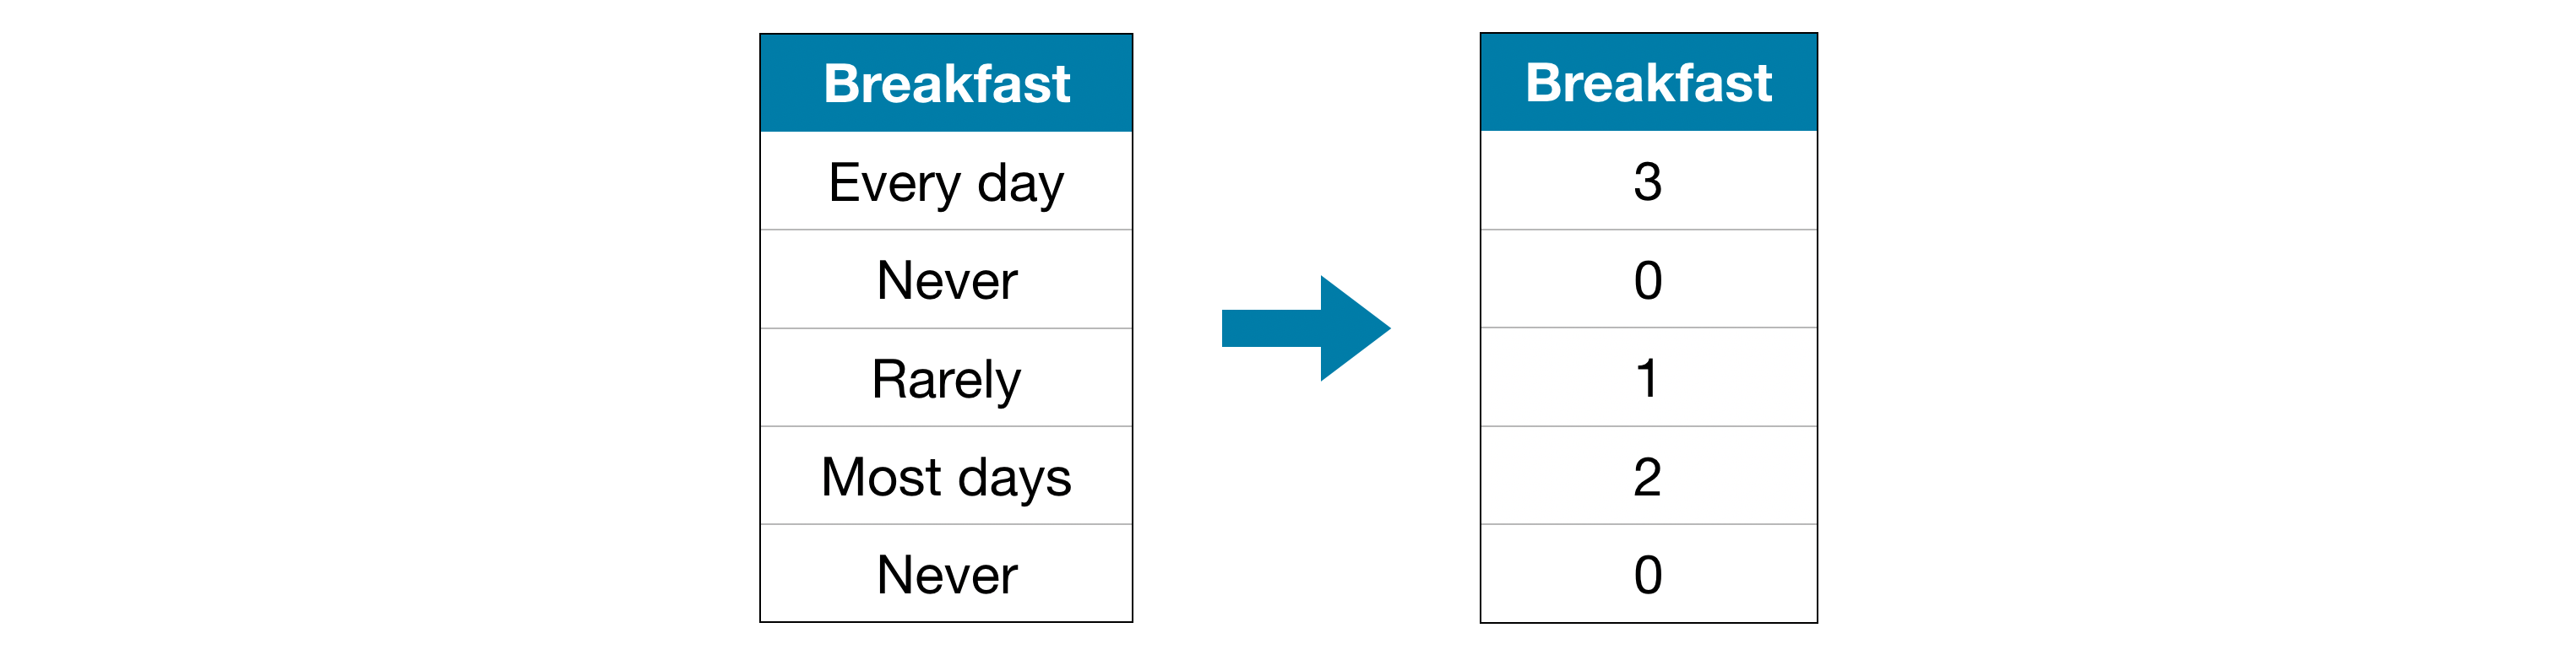

In [3]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df_train = pd.DataFrame({'A': ['a', 'b', 'c'], 'B': ['b', 'a', 'c'],
                         'C': [1, 2, 3]})
df_valid = pd.DataFrame({'A': ['c', 'a', 'd'], 'B': ['c', 'b', 'a'],
                         'C': [1, 2, 3]})

cat_cols =['A','B']

df_train

,A,B,C
0,a,b,1
1,b,a,2
2,c,c,3


In [4]:
df_valid

,A,B,C
0,c,c,1
1,a,b,2
2,d,a,3


In [5]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cat_cols:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_valid[col] = label_encoder.transform(df_valid[col])

df_train

ValueError: y contains new labels: ['d']

In [8]:
df_valid

,A,B,C
0,c,c,1
1,a,b,2
2,d,a,3


**One-hot encoding** creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

Beware of dummy variable traps!

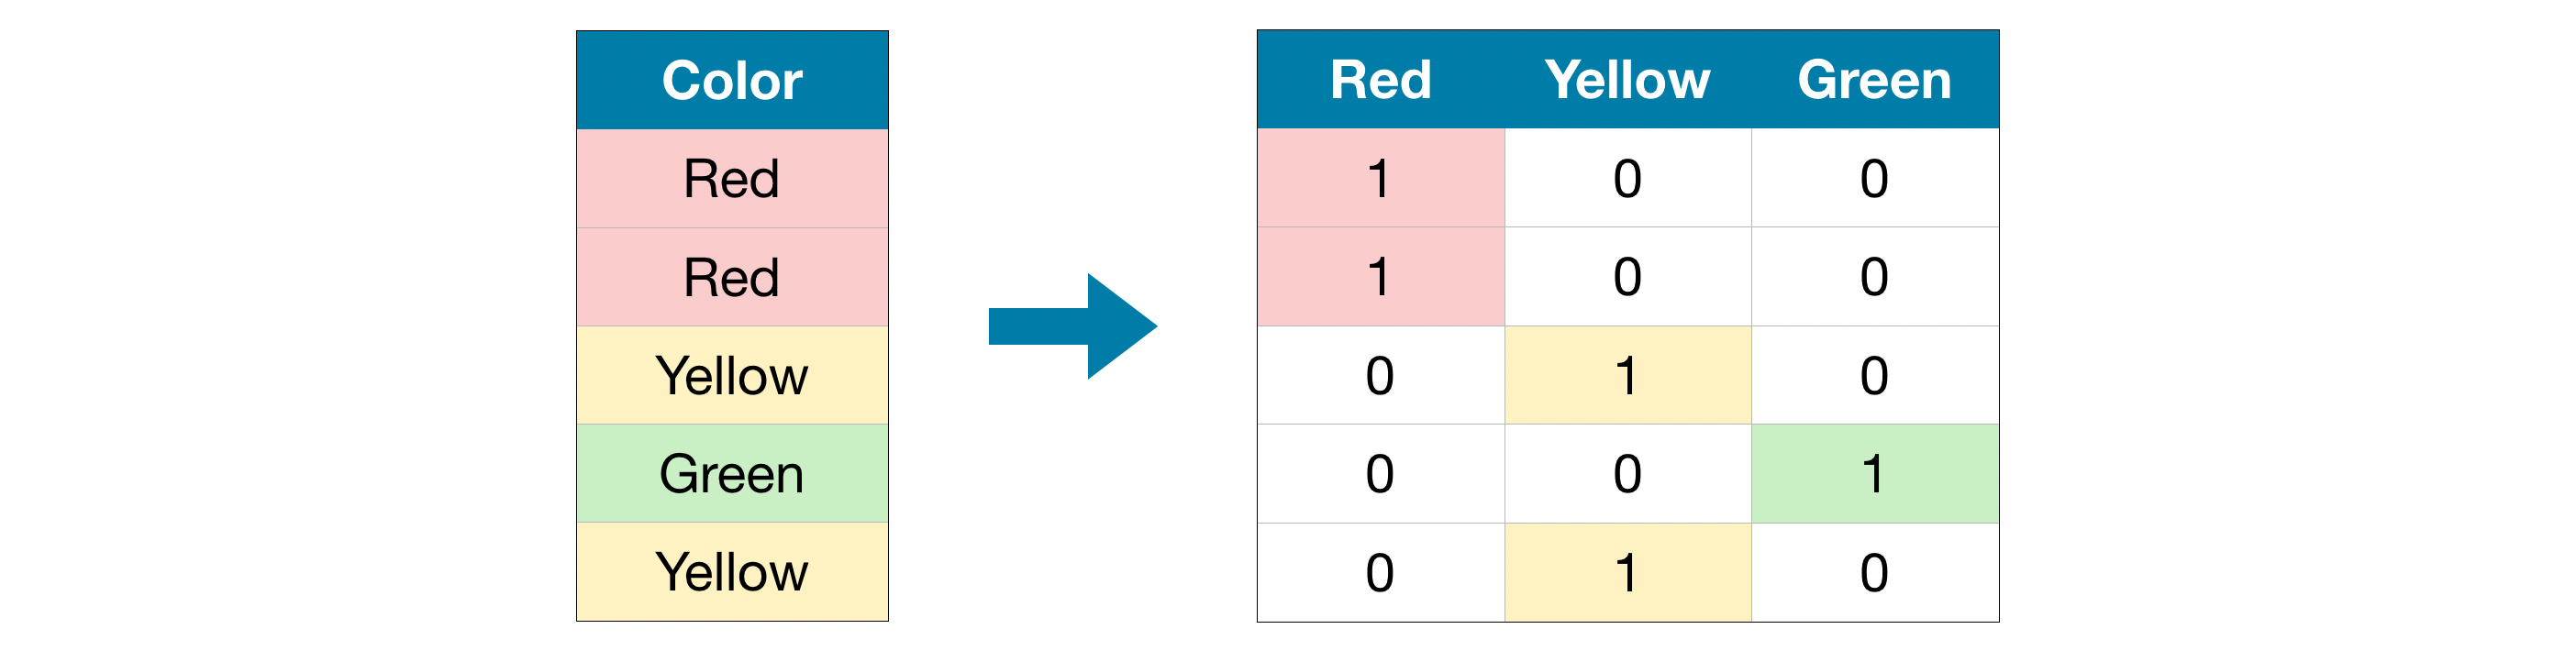

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values

In [9]:
df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})

In [10]:
df

,A,B,C
0,a,b,1
1,b,a,2
2,a,c,3


In [11]:
pd.get_dummies(df)

,C,A_a,A_b,B_a,B_b,B_c
0,1,1,0,0,1,0
1,2,0,1,1,0,0
2,3,1,0,0,0,1


#### More Encoding methods: Category Encoders

https://contrib.scikit-learn.org/categorical-encoding/index.html

In [12]:
#To install
#!pip install category_encoders
# or
# conda install -c conda-forge category_encoders

In [13]:
# To use
'''
import category_encoders as ce

encoder = ce.BackwardDifferenceEncoder(cols=[...])
encoder = ce.BaseNEncoder(cols=[...])
encoder = ce.BinaryEncoder(cols=[...])
encoder = ce.CatBoostEncoder(cols=[...])
encoder = ce.HashingEncoder(cols=[...])
encoder = ce.HelmertEncoder(cols=[...])
encoder = ce.JamesSteinEncoder(cols=[...])
encoder = ce.LeaveOneOutEncoder(cols=[...])
encoder = ce.MEstimateEncoder(cols=[...])
encoder = ce.OneHotEncoder(cols=[...])
encoder = ce.OrdinalEncoder(cols=[...])
encoder = ce.SumEncoder(cols=[...])
encoder = ce.PolynomialEncoder(cols=[...])
encoder = ce.TargetEncoder(cols=[...])
encoder = ce.WOEEncoder(cols=[...])

encoder.fit(X, y)
X_cleaned = encoder.transform(X_dirty)
'''

'\nimport category_encoders as ce\n\nencoder = ce.BackwardDifferenceEncoder(cols=[...])\nencoder = ce.BaseNEncoder(cols=[...])\nencoder = ce.BinaryEncoder(cols=[...])\nencoder = ce.CatBoostEncoder(cols=[...])\nencoder = ce.HashingEncoder(cols=[...])\nencoder = ce.HelmertEncoder(cols=[...])\nencoder = ce.JamesSteinEncoder(cols=[...])\nencoder = ce.LeaveOneOutEncoder(cols=[...])\nencoder = ce.MEstimateEncoder(cols=[...])\nencoder = ce.OneHotEncoder(cols=[...])\nencoder = ce.OrdinalEncoder(cols=[...])\nencoder = ce.SumEncoder(cols=[...])\nencoder = ce.PolynomialEncoder(cols=[...])\nencoder = ce.TargetEncoder(cols=[...])\nencoder = ce.WOEEncoder(cols=[...])\n\nencoder.fit(X, y)\nX_cleaned = encoder.transform(X_dirty)\n'

**CatBoost**

CatBoost has the flexibility of giving indices of categorical columns so that it can be encoded as **one-hot encoding using one_hot_max_size** (Use one-hot encoding for all features with number of different values less than or equal to the given parameter value).

**For categorical columns which have unique number of categories greater than one_hot_max_size,** CatBoost uses an efficient method of encoding which is similar to mean encoding but reduces overfitting.

If you don’t pass any anything in cat_features argument, CatBoost will treat all the columns as numerical variables.

**LightGBM**

Similar to CatBoost, LightGBM can also handle categorical features by taking the input of feature names. It does not convert to one-hot coding, and is much faster than one-hot coding. LGBM uses a special algorithm to find the split value of categorical features.

**Note**: You should convert your categorical features to **int** type before you construct Dataset for LGBM. It does not accept string values even if you passes it through categorical_feature parameter.

**XGBoost**

Unlike CatBoost or LGBM, XGBoost cannot handle categorical features by itself, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, mean encoding or one-hot encoding before supplying categorical data to XGBoost.

## 2. Differences in Hyperparameters

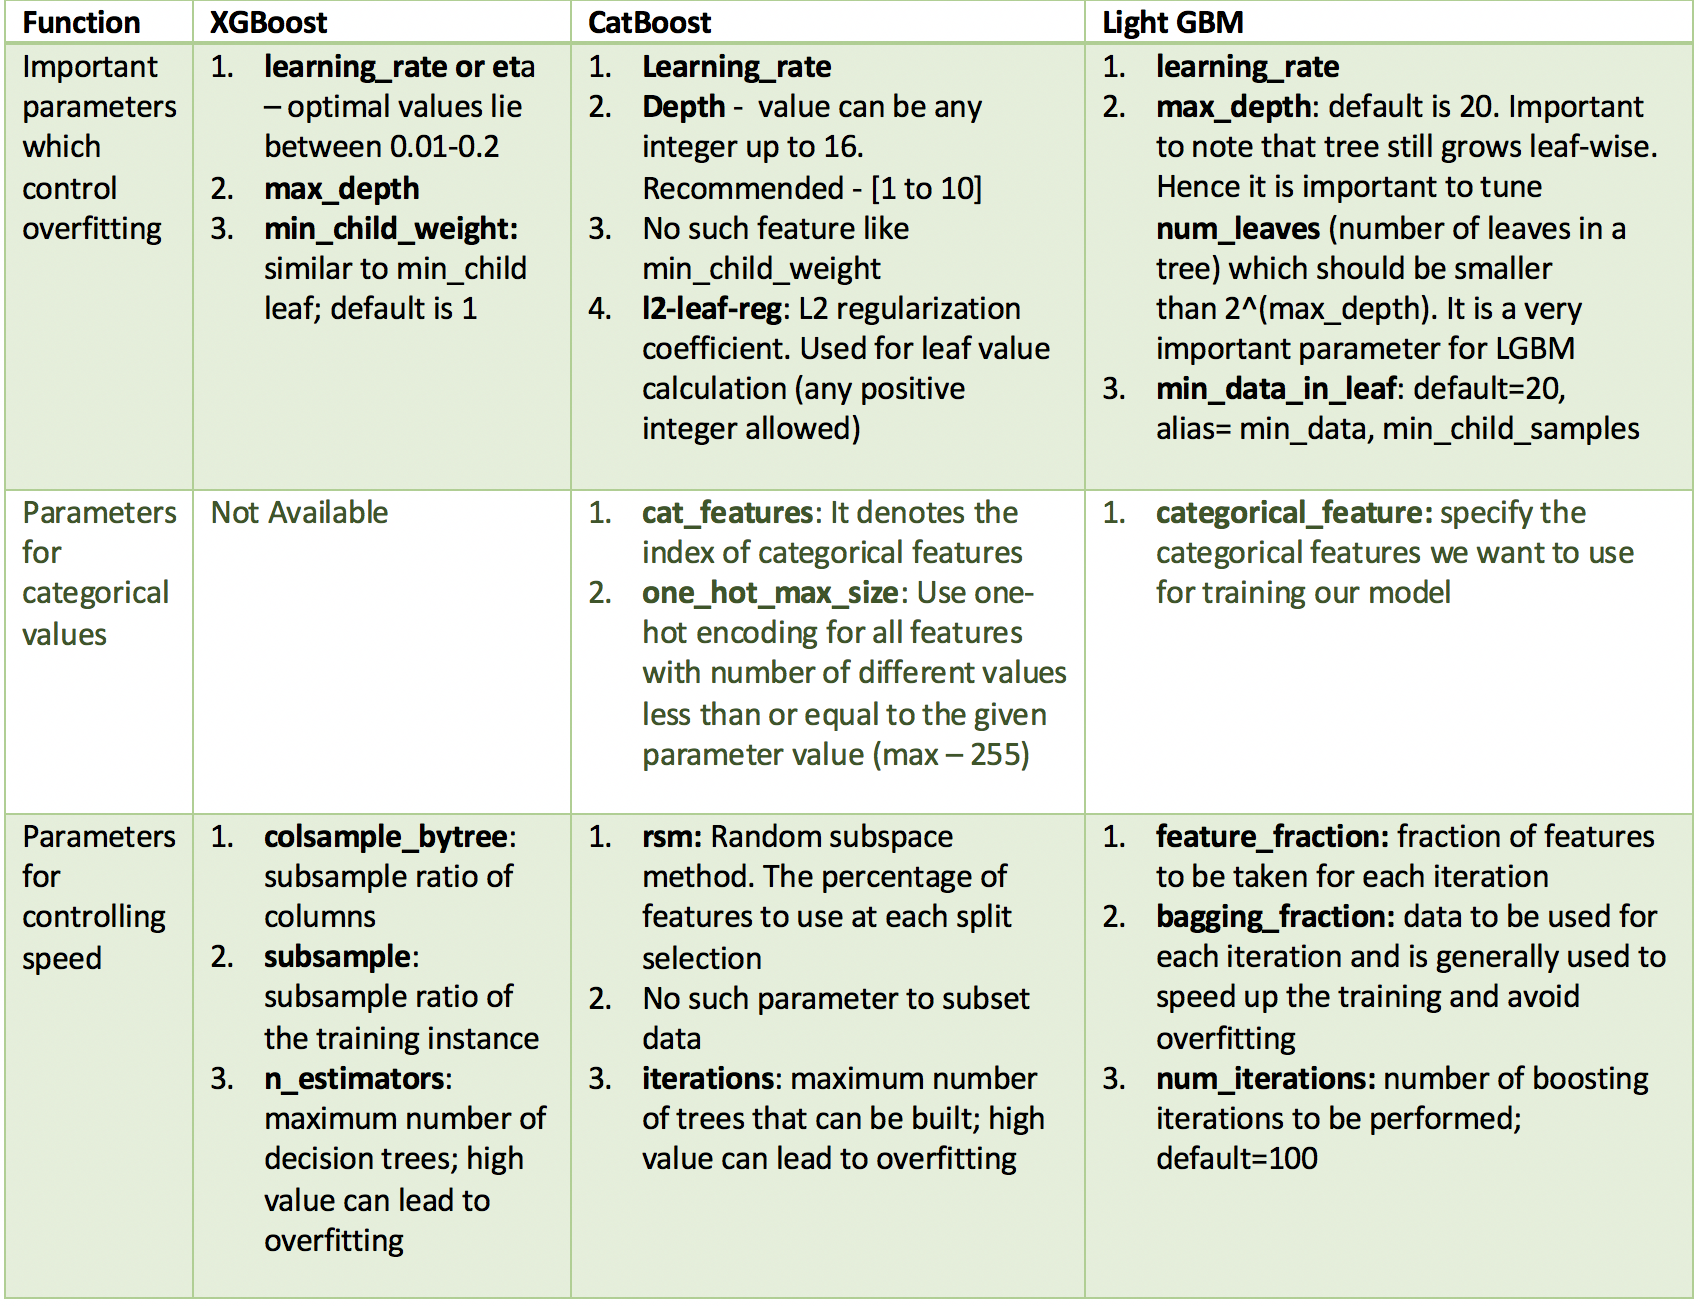

## 3. Examples of Using Them

### 3.1 Prepare dataset -- Churn dataset

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as AUC, log_loss

In [15]:
churn=pd.read_csv("train_new_features_no_missing.csv")
churn.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_year', 'registration_month', 'registration_day',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'trans_year',
       'trans_month', 'trans_day', 'trans_expiration_year',
       'trans_expiration_month', 'trans_expiration_day', 'discount_value',
       'discount_y', 'amount_per_day', 'day_from_last', 'trans_count',
       'cancel_count', 'discount_freq', 'renew_freq', 'discount_std',
       'cancel_freq', 'price_increase', 'num_100 size', 'num_100 mean',
       'num_100 std', 'num_100 skew', 'num_25 mean', 'num_25 std',
       'num_25 skew', 'num_50 mean', 'num_50 std', 'num_50 skew',
       'num_75 mean', 'num_75 std', 'num_75 skew', 'num_985 mean',
       'num_985 std', 'num_985 skew', 'num_unq mean', 'num_unq std',
       'num_unq skew', 'total_song sum', 'total_song mean', 'total_song std',
       'total_song skew',

In [16]:
X=churn.iloc[:,2:]
y=churn.iloc[:,1]

In [17]:
X.columns

Index(['city', 'bd', 'gender', 'registered_via', 'registration_year',
       'registration_month', 'registration_day', 'payment_method_id',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'is_auto_renew', 'is_cancel', 'trans_year', 'trans_month', 'trans_day',
       'trans_expiration_year', 'trans_expiration_month',
       'trans_expiration_day', 'discount_value', 'discount_y',
       'amount_per_day', 'day_from_last', 'trans_count', 'cancel_count',
       'discount_freq', 'renew_freq', 'discount_std', 'cancel_freq',
       'price_increase', 'num_100 size', 'num_100 mean', 'num_100 std',
       'num_100 skew', 'num_25 mean', 'num_25 std', 'num_25 skew',
       'num_50 mean', 'num_50 std', 'num_50 skew', 'num_75 mean', 'num_75 std',
       'num_75 skew', 'num_985 mean', 'num_985 std', 'num_985 skew',
       'num_unq mean', 'num_unq std', 'num_unq skew', 'total_song sum',
       'total_song mean', 'total_song std', 'total_song skew',
       'unique_song_ratio 

In [18]:
X.dtypes[X.dtypes=='object']

gender               object
registered_via       object
max_column c_mode    object
min_column c_mode    object
dtype: object

In [19]:
X['max_column c_mode'].value_counts()

num_100    778787
0          123005
num_25      86930
num_50       2813
num_985      1005
num_75        391
Name: max_column c_mode, dtype: int64

In [20]:
X['gender'].value_counts()

Unknown    596874
male       208200
female     187857
Name: gender, dtype: int64

In [21]:
X['registered_via'].value_counts()

7.0        481759
9.0        236583
Unknown    116788
3.0        105441
4.0         49282
13.0         3078
Name: registered_via, dtype: int64

### Some categorical variables are in strings, some are in integers.

In [22]:
cat_cols = ['city', 'gender', 'registered_via', 'payment_method_id','is_auto_renew',
            'is_cancel', 'discount_y','max_column c_mode','min_column c_mode','bd_missing']           

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.07 ,test_size=0.03, random_state=10000)


In [24]:
X_train.shape

(69505, 67)

In [25]:
X_test.shape

(29788, 67)

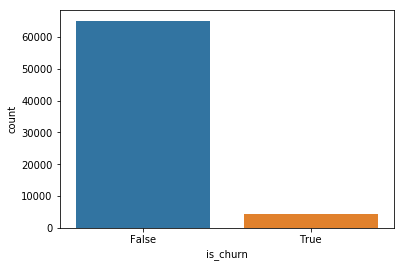

In [26]:
sns.countplot(y_train)

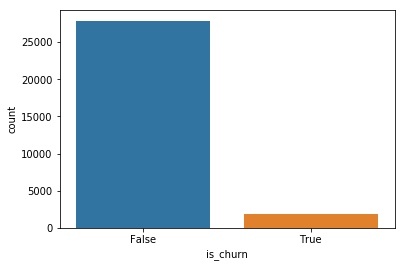

In [27]:
sns.countplot(y_test)

### 3.2 Xgboost

Xgboost: https://xgboost.readthedocs.io/en/latest/

#### 3.2.1 First, you need to convert string to integers for those categorical variables.

In [28]:
'''
X_train_xgb = pd.get_dummies(X_train,columns=['max_column c_mode','min_column c_mode','gender','registered_via'])
X_test_xgb=pd.get_dummies(X_test,columns=['max_column c_mode','min_column c_mode','gender','registered_via'])
'''

"\nX_train_xgb = pd.get_dummies(X_train,columns=['max_column c_mode','min_column c_mode','gender','registered_via'])\nX_test_xgb=pd.get_dummies(X_test,columns=['max_column c_mode','min_column c_mode','gender','registered_via'])\n"

In [29]:
X_train_xgb = pd.get_dummies(X_train,columns=cat_cols)
X_test_xgb=pd.get_dummies(X_test,columns=cat_cols)

**Double check whether X_train and X_test have the same columns**

In [30]:
X_train_xgb.columns

Index(['bd', 'registration_year', 'registration_month', 'registration_day',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'trans_year', 'trans_month', 'trans_day',
       ...
       'max_column c_mode_num_75', 'max_column c_mode_num_985',
       'min_column c_mode_0', 'min_column c_mode_num_100',
       'min_column c_mode_num_25', 'min_column c_mode_num_50',
       'min_column c_mode_num_75', 'min_column c_mode_num_985',
       'bd_missing_False', 'bd_missing_True'],
      dtype='object', length=140)

In [31]:
X_test_xgb.columns

Index(['bd', 'registration_year', 'registration_month', 'registration_day',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'trans_year', 'trans_month', 'trans_day',
       ...
       'max_column c_mode_num_75', 'max_column c_mode_num_985',
       'min_column c_mode_0', 'min_column c_mode_num_100',
       'min_column c_mode_num_25', 'min_column c_mode_num_50',
       'min_column c_mode_num_75', 'min_column c_mode_num_985',
       'bd_missing_False', 'bd_missing_True'],
      dtype='object', length=138)

#### Columns not in training dataset but in test dataset


In [32]:
not_train_cols = [c for c in list(X_test_xgb.columns) if c not in list(X_train_xgb.columns)]

In [33]:
not_train_cols

[]

#### Columns not in test dataset but in training dataset

In [34]:
not_test_cols = [c for c in list(X_train_xgb.columns) if c not in list(X_test_xgb.columns)]

In [35]:
not_test_cols

['payment_method_id_3', 'payment_method_id_6']

**Ad hoc solution:**

Adding missing columns in both train and test with setting the value as 0.

In [36]:
for x in not_train_cols:
    X_train_xgb [x]=0

In [37]:
for x in not_test_cols:
    X_test_xgb [x]=0

In [38]:
len(X_test_xgb.columns)

140

In [39]:
len(X_train_xgb.columns)

140

#### Make sure that features in test and training datasets are in the same order!

In [40]:
X_test_xgb=X_test_xgb[X_train_xgb.columns]

#### 3.2.2 Xgboost syntax:

+ Data interface
+ Model hyperparameters
+ Model training
+ Early stopping
+ Prediction
+ Plotting


#### 3.2.2.1 Data interface

The XGBoost python module is able to load data from:

+ LibSVM text format file

+ Comma-separated values (CSV) file

+ NumPy 2D array

+ SciPy 2D sparse array

+ cuDF DataFrame

+ Pandas data frame, and

+ XGBoost binary buffer file.


**The data is stored in a DMatrix object.**

Example of pandas dataframe, you can also filling missing values with a specific value:

> `dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)`


In [41]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dvalid = xgb.DMatrix(X_test_xgb, y_test)

C:\Users\micha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### 3.2.2.2 Model hyperparameters

XGBoost can use either a list of pairs or a dictionary to set parameters. For more info on parameters, see https://xgboost.readthedocs.io/en/latest/parameter.html

For example:
> `param = {'max_depth': 2,
         'eta': 1, 
         'objective': 'binary:logistic'}`

In [42]:
params = {
        'eta': 0.02, 
        'max_depth': 6,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
         }

#### 3.2.2.3 Model training

Training a model requires a parameter list and data set. You can add more parameters, for example number of rounds to run:

> `num_round = 10 
model = xgb.train(params, dtrain, num_round)`



In [43]:
model = xgb.train(params, dtrain, 100) 


#### 3.2.2.4 Early stopping

If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. Early stopping requires at least one set in **`evals`**.

The model will train until the validation score stops improving. Validation error needs to decrease at least every **`early_stopping_rounds`** to continue training. You can also control how much to print out using **`verbose_eval`**, it only prints out the evaluation every **`verbose_eval`** round.

When you use **`evals`**, it takes in a list of pairs (DMatrix, string), e.g.:
> `evals=[(dtrain,'train'),(dvalid,'valid')]`

In [44]:
s=time.time()

model = xgb.train(params, dtrain, 500,evals=[(dtrain,'train'),(dvalid,'valid')],early_stopping_rounds=50,verbose_eval=50 ) 

print('Traing used {:.2f} seconds'.format(time.time()-s))

[0]	train-logloss:0.674771	valid-logloss:0.674871
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.234651	valid-logloss:0.237927
[100]	train-logloss:0.115564	valid-logloss:0.121879
[150]	train-logloss:0.074657	valid-logloss:0.084059
[200]	train-logloss:0.059428	valid-logloss:0.071396
[250]	train-logloss:0.052909	valid-logloss:0.066813
[300]	train-logloss:0.049571	valid-logloss:0.065226
[350]	train-logloss:0.04734	valid-logloss:0.064645
[400]	train-logloss:0.045573	valid-logloss:0.064334
[450]	train-logloss:0.043902	valid-logloss:0.064241
Stopping. Best iteration:
[444]	train-logloss:0.044126	valid-logloss:0.064216

Traing used 31.33 seconds


#### 3.2.2.5 Prediction
A model that has been trained or loaded can perform predictions on data sets.

If early stopping is enabled during training, **you can get predictions from the best iteration with `bst.best_ntree_limit`.**

> `pred = model.predict(dtest, ntree_limit=bst.best_ntree_limit)`

In [45]:
pred_y = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
print('test log loss is {}\n'.format(log_loss(y_test,pred_y)))

test log loss is 0.06421604609438906



#### Combining these parts together:


In [46]:
'''
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dvalid = xgb.DMatrix(X_test_xgb, y_test)

params = {
        'eta': 0.02, 
        'max_depth': 6,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 1,
        'silent': True
         }

s=time.time()
model = xgb.train(params, dtrain, 1000,evals=dvalid,early_stopping_rounds=50,verbose_eval=50 ) 
print('time used:',time.time()-s)         
         
pred_y = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
print('test log loss is {}\n'.format(log_loss(y_test,pred_y)))         
'''

"\nimport xgboost as xgb\n\ndtrain = xgb.DMatrix(X_train_xgb, y_train)\ndvalid = xgb.DMatrix(X_test_xgb, y_test)\n\nparams = {\n        'eta': 0.02, \n        'max_depth': 6,\n        'objective': 'binary:logistic',\n        'eval_metric': 'logloss',\n        'seed': 1,\n        'silent': True\n         }\n\ns=time.time()\nmodel = xgb.train(params, dtrain, 1000,evals=dvalid,early_stopping_rounds=50,verbose_eval=50 ) \nprint('time used:',time.time()-s)         \n         \npred_y = model.predict(dvalid, ntree_limit=model.best_ntree_limit)\nprint('test log loss is {}\n'.format(log_loss(y_test,pred_y)))         \n"

#### 3.2.2.6 Plotting the feature importance

You can use plotting module to plot importance and output tree.

To plot importance, use `xgboost.plot_importance()`. This function requires matplotlib to be installed.

> `xgb.plot_importance(model)`

You can control how many top features to plot using `max_num_features `.

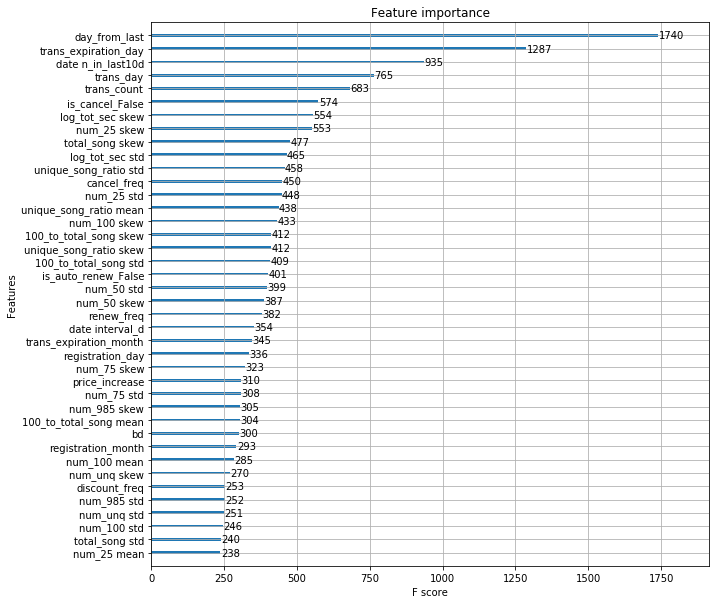

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

xgb.plot_importance(model,max_num_features =40)

### 3.3 Lightgbm
#### 3.3.1 Preparing data

Lightgbm does not using one hot encoding for categorical features, **but it requires categorical features to be in integer!**

In [48]:
for col in ['max_column c_mode','min_column c_mode','gender','registered_via']:
    print(X_train[col].value_counts())
    print(X_test[col].value_counts())

num_100    54329
0           8687
num_25      6203
num_50       196
num_985       65
num_75        25
Name: max_column c_mode, dtype: int64
num_100    23340
0           3675
num_25      2659
num_50        78
num_985       25
num_75        11
Name: max_column c_mode, dtype: int64
num_50     26001
num_25     23995
0           8687
num_75      8498
num_985     2187
num_100      137
Name: min_column c_mode, dtype: int64
num_50     11145
num_25     10266
num_75      3709
0           3675
num_985      937
num_100       56
Name: min_column c_mode, dtype: int64
Unknown    41821
male       14629
female     13055
Name: gender, dtype: int64
Unknown    17960
male        6225
female      5603
Name: gender, dtype: int64
7.0        33649
9.0        16522
Unknown     8243
3.0         7412
4.0         3462
13.0         217
Name: registered_via, dtype: int64
7.0        14475
9.0         7129
Unknown     3501
3.0         3148
4.0         1464
13.0          71
Name: registered_via, dtype: int64


#### So, we use LabelEncoder to convert strings into integers.

The test dataset may have new, previously unseen labels, one walkaround is to add a new feature called 'unseen labels' and set a special value for it, e.g., 999, or -999.

We use a dictionary to store label and integer pair, and if the label is previously unseen, we give it a special value.

In [49]:
label_encoder = LabelEncoder()
X_train_light = X_train.copy()
X_test_light = X_test.copy()

for col in ['max_column c_mode','min_column c_mode','gender','registered_via']:
    X_train_light[col] = label_encoder.fit_transform(X_train_light[col])
    label_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    X_test_light[col]=X_test_light[col].apply(lambda x: label_dict.get(x, 999))


In [50]:
label_encoder.classes_

array(['13.0', '3.0', '4.0', '7.0', '9.0', 'Unknown'], dtype=object)

In [51]:
label_encoder.transform(label_encoder.classes_)

array([0, 1, 2, 3, 4, 5], dtype=int64)

**Using get() function of dictionary is preferable, as compared with [] indexing, it will not raise an exception if there is an unseen key**



In [52]:
d= {"A":2,"B":9}

In [53]:
d['C']

KeyError: 'C'

In [54]:
d.get("C",999)

999

### 3.3.2 Lightgbm sytax:

+ Data interface
+ Model hyperparameters
+ Model training/early stopping
+ Prediction
+ Plotting

#### 3.3.2.1 Data Interface
The LightGBM Python module can load data from:
+ LibSVM (zero-based) / TSV / CSV / TXT format file
+ NumPy 2D array(s), pandas DataFrame, H2O DataTable’s Frame, SciPy sparse matrix
+ LightGBM binary file

The data is stored in a Dataset object.

In [55]:
import lightgbm as lgb

In [56]:
train_data = lgb.Dataset(X_train_light, label=y_train)
validation_data = lgb.Dataset(X_test_light, label=y_test)

#### 3.3.2.2 Setting model hyperparameters

LightGBM can use a dictionary to set Parameters as Xgboost.

see https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [57]:
lgb_params ={"max_depth": 6,
             "learning_rate" : 0.2,
            #"num_leaves": 1000,
            #"n_estimators": 500,
             'objective': 'binary',
             'metric':'binary_logloss'
             }

#### 3.3.2.3 Model training/early stopping/prediction

Training a model requires a parameter list and data set.

If you have a validation set, you can use **early stopping** to find the optimal number of boosting rounds. Early stopping requires at least one set in **`valid_sets`**.

The model will train until the validation score stops improving. Validation score needs to improve at least every **`early_stopping_rounds`** to continue training.

**`verbose_eval`** decides every boosting rounds to print out evaluation results.

**Prediction** is similar to Xgboost (If early stopping is enabled during training, you can get predictions from the best iteration with **`model.best_iteration`**):

> `ypred = model.predict(data, num_iteration=model.best_iteration)`


In [58]:
s = time.time()
model_light = lgb.train(lgb_params, train_set=train_data, num_boost_round=500, valid_sets=validation_data, 
                        early_stopping_rounds=50, verbose_eval=25) 
print('\n Training used {:.2f} seconds'.format(time.time()-s))

lgb_pred = model_light.predict(X_test_light,num_iteration=model_light.best_iteration)

print('\n test log loss is {}\n'.format(log_loss(y_test,lgb_pred))) 

Training until validation scores don't improve for 50 rounds
[25]	valid_0's binary_logloss: 0.0660938
[50]	valid_0's binary_logloss: 0.0674992
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0658502

 Training used 1.15 seconds

 test log loss is 0.06585023291957912



#### 3.3.2.4 Plotting the feature importance


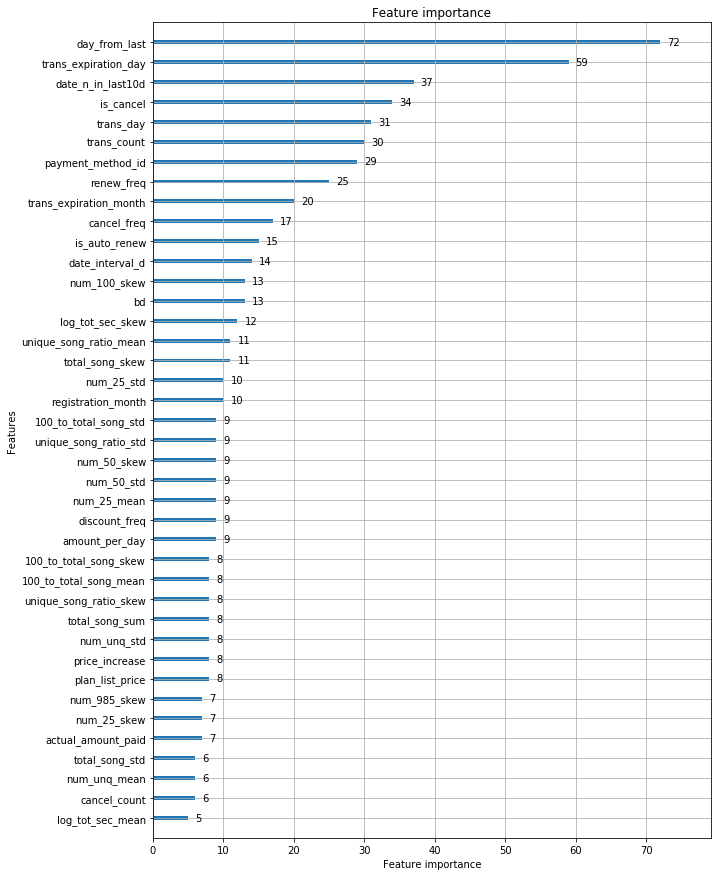

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

lgb.plot_importance(model_light,max_num_features = 40,figsize = (10,15))

### 3.3.3 Combining all previous steps

#### 3.3.3.1 Lightgbm without using categorical features

In [60]:
import lightgbm as lgb

lgb_params ={"max_depth": 6,
         "learning_rate" : 0.2,
         #"num_leaves": 1000,
         #"n_estimators": 500,
         'objective': 'binary',
         'metric':'binary_logloss'
             }

train_data = lgb.Dataset(X_train_light, label=y_train)
validation_data = lgb.Dataset(X_test_light, label=y_test)


s=time.time()
model_light = lgb.train(lgb_params, train_set=train_data, num_boost_round=500, valid_sets=validation_data, 
                        early_stopping_rounds=50, verbose_eval=25) 
print('\n Training used {:.2f} seconds'.format(time.time()-s))

lgb_pred = model_light.predict(X_test_light,num_iteration=model_light.best_iteration)

print('\n test log loss is {}\n'.format(log_loss(y_test,lgb_pred))) 

Training until validation scores don't improve for 50 rounds
[25]	valid_0's binary_logloss: 0.0660938
[50]	valid_0's binary_logloss: 0.0674992
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0658502

 Training used 1.14 seconds

 test log loss is 0.06585023291957912



#### 3.3.3.2 Lightgbm using categorical features

In [61]:
import lightgbm as lgb

lgb_params ={"max_depth": 6,
         "learning_rate" : 0.2,
         #"num_leaves": 1000,
         #"n_estimators": 500,
         'objective': 'binary',
         'metric':'binary_logloss'
             }

train_data = lgb.Dataset(X_train_light, label=y_train)
validation_data = lgb.Dataset(X_test_light, label=y_test)


s=time.time()
model_light = lgb.train(lgb_params, train_set=train_data, num_boost_round=500, valid_sets=validation_data, 
                  categorical_feature = cat_cols,early_stopping_rounds=50, verbose_eval=25) 

print('\n Training used {:.2f} seconds'.format(time.time()-s))

lgb_pred = model_light.predict(X_test_light,num_iteration=model_light.best_iteration)

print('\n test log loss is {}\n'.format(log_loss(y_test,lgb_pred))) 

C:\Users\micha\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bd_missing', 'city', 'discount_y', 'gender', 'is_auto_renew', 'is_cancel', 'max_column c_mode', 'min_column c_mode', 'payment_method_id', 'registered_via']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\micha\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bd_missing', 'city', 'discount_y', 'gender', 'is_auto_renew', 'is_cancel', 'max_column c_mode', 'min_column c_mode', 'payment_method_id', 'registered_via']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[25]	valid_0's binary_logloss: 0.0653465
[50]	valid_0's binary_logloss: 0.066169
[75]	valid_0's binary_logloss: 0.0672946
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.0652347

 Training used 1.13 seconds

 test log loss is 0.06523469695578582



### 3.4 Catboost

We also try catboost **with and without** specifying categorical features.

For without specifying categorical features, we need those cat features to be integers, so we try two ways:

+ one-hot encoding
+ label encoding

### 3.4.1 Catboost Syntax:
Similar to Xgboost and lightgbm:

+ Data interface
+ Model hyperparameter
+ Model training/early stopping
+ Plotting

In [62]:
from catboost import CatBoost, Pool

#### 3.4.1.1 Data interface
Datasets can be read from similar input files as in Xgboost and Lightgbm. The Pool class processes the data.

**The target or lable or y has to be integer as well!**

In [63]:
y_train = y_train.astype('int8')
y_test = y_test.astype('int8')

train_pool = Pool(X_train_xgb, y_train)

valid_pool = Pool(X_test_xgb,y_test) 

#### 3.4.1.2 Model hyperparameter/training/early stopping/prediction

The hyperparameters are in dictionary as in Xgboost and lightgbm, see https://catboost.ai/docs/concepts/python-reference_parameters-list.html

Training is similar to sklearn, first create a model, then use **`model.fit()`**.

Early stopping is similar to Xgboost and lightgbm as well.

**Prediction** is a little different, you need to specify prediction type, either the "class" or the "probability", or "RawFormulaVal".
> `preds_class = model.predict(test_pool, prediction_type='Class')
preds_proba = model.predict(test_pool, prediction_type='Probability')
preds_raw_vals = model.predict(test_pool, prediction_type='RawFormulaVal')`

In [64]:
cat_params = {'iterations':500,
              'learning_rate' : 0.2,
             'depth':6,
             'loss_function':'Logloss',
             'eval_metric':'Logloss',
             'random_seed':1
             }

model_cat = CatBoost(cat_params)

#train the model
s = time.time()
model_cat.fit(train_pool,eval_set=valid_pool,early_stopping_rounds=50,verbose_eval=25) 
print('\n Training used {:.2f} seconds'.format(time.time()-s))

#prediction
preds_class = model_cat.predict(valid_pool, prediction_type='Class')
preds_proba = model_cat.predict(valid_pool, prediction_type='Probability')
preds_raw_vals = model_cat.predict(valid_pool, prediction_type='RawFormulaVal')

print('\n test log loss is {}\n'.format(log_loss(y_test,preds_proba))) 

0:	learn: 0.3214967	test: 0.3223577	best: 0.3223577 (0)	total: 84.3ms	remaining: 42.1s
25:	learn: 0.0640110	test: 0.0698232	best: 0.0698232 (25)	total: 618ms	remaining: 11.3s
50:	learn: 0.0594478	test: 0.0690218	best: 0.0690183 (48)	total: 1.24s	remaining: 10.9s
75:	learn: 0.0563834	test: 0.0686898	best: 0.0686368 (72)	total: 1.87s	remaining: 10.4s
100:	learn: 0.0528489	test: 0.0680498	best: 0.0680498 (100)	total: 2.52s	remaining: 9.95s
125:	learn: 0.0493306	test: 0.0678022	best: 0.0677866 (122)	total: 3.13s	remaining: 9.29s
150:	learn: 0.0466530	test: 0.0678985	best: 0.0677866 (122)	total: 3.88s	remaining: 8.96s
175:	learn: 0.0434287	test: 0.0676175	best: 0.0675689 (168)	total: 4.53s	remaining: 8.34s
200:	learn: 0.0410683	test: 0.0676657	best: 0.0673665 (189)	total: 5.19s	remaining: 7.72s
225:	learn: 0.0385610	test: 0.0677850	best: 0.0673665 (189)	total: 5.79s	remaining: 7.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06736645996
bestIteration = 189

Shrink m

####  3.4.2 Without using categorical variables

Then, we need to make sure every feature is numerical.

we can try one-hot encoding as in Xgboost and then label encoding as in lightgbm.

**One-hot encoding**: copy xgb data

In [65]:
X_train_cat = X_train_xgb.copy()
X_test_cat = X_test_xgb.copy()
y_train = y_train.astype('int8')
y_test = y_test.astype('int8')

In [66]:
train_pool = Pool(X_train_cat, y_train)
valid_pool = Pool(X_test_cat,y_test) 

cat_params = {'iterations':500,
        'learning_rate' : 0.2,
        'depth':6,
        'loss_function':'Logloss',
        'eval_metric':'Logloss',
        'random_seed':1
        }

model_cat = CatBoost(cat_params)

#train the model
s = time.time()
model_cat.fit(train_pool,eval_set=valid_pool,early_stopping_rounds=50,verbose_eval=25) 
print('\n Training used {:.2f} seconds'.format(time.time()-s))

#prediction
preds_proba = model_cat.predict(valid_pool, prediction_type='Probability')

print('\n test log loss is {}\n'.format(log_loss(y_test,preds_proba))) 

0:	learn: 0.3214967	test: 0.3223577	best: 0.3223577 (0)	total: 23.9ms	remaining: 11.9s
25:	learn: 0.0640110	test: 0.0698232	best: 0.0698232 (25)	total: 637ms	remaining: 11.6s
50:	learn: 0.0594478	test: 0.0690218	best: 0.0690183 (48)	total: 1.22s	remaining: 10.8s
75:	learn: 0.0563834	test: 0.0686898	best: 0.0686368 (72)	total: 1.91s	remaining: 10.7s
100:	learn: 0.0528489	test: 0.0680498	best: 0.0680498 (100)	total: 2.62s	remaining: 10.3s
125:	learn: 0.0493306	test: 0.0678022	best: 0.0677866 (122)	total: 3.28s	remaining: 9.73s
150:	learn: 0.0466530	test: 0.0678985	best: 0.0677866 (122)	total: 3.97s	remaining: 9.18s
175:	learn: 0.0434287	test: 0.0676175	best: 0.0675689 (168)	total: 4.63s	remaining: 8.51s
200:	learn: 0.0410683	test: 0.0676657	best: 0.0673665 (189)	total: 5.28s	remaining: 7.86s
225:	learn: 0.0385610	test: 0.0677850	best: 0.0673665 (189)	total: 6s	remaining: 7.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06736645996
bestIteration = 189

Shrink mode

#### Label encoding

Copy data from lightgbm label encoding.

In [67]:
X_train_cat = X_train_light.copy()
X_test_cat = X_test_light.copy()
y_train = y_train.astype('int8')
y_test = y_test.astype('int8')

train_pool = Pool(X_train_cat, y_train)

valid_pool = Pool(X_test_cat,y_test) 

cat_params = {'iterations':500,
        'learning_rate' : 0.2,
        'depth':6,
        'loss_function':'Logloss',
        'eval_metric':'Logloss',
        'random_seed':1
        }

model_cat = CatBoost(cat_params)

#train the model
s = time.time()
model_cat.fit(train_pool,eval_set=valid_pool,early_stopping_rounds=50,verbose_eval=25) 
print('\n Training used {:.2f} seconds'.format(time.time()-s))

#prediction
preds_proba = model_cat.predict(valid_pool, prediction_type='Probability')

print('\n test log loss is {}\n'.format(log_loss(y_test,preds_proba))) 

0:	learn: 0.3047922	test: 0.3049677	best: 0.3049677 (0)	total: 30.3ms	remaining: 15.1s
25:	learn: 0.0635642	test: 0.0698816	best: 0.0698816 (25)	total: 666ms	remaining: 12.1s
50:	learn: 0.0587738	test: 0.0685918	best: 0.0685697 (46)	total: 1.27s	remaining: 11.2s
75:	learn: 0.0555821	test: 0.0684356	best: 0.0683973 (69)	total: 1.96s	remaining: 10.9s
100:	learn: 0.0523711	test: 0.0685895	best: 0.0683659 (89)	total: 2.62s	remaining: 10.4s
125:	learn: 0.0493995	test: 0.0684549	best: 0.0683659 (89)	total: 3.3s	remaining: 9.79s
150:	learn: 0.0461922	test: 0.0684164	best: 0.0682224 (141)	total: 3.88s	remaining: 8.98s
175:	learn: 0.0439267	test: 0.0687179	best: 0.0682224 (141)	total: 4.47s	remaining: 8.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06822236261
bestIteration = 141

Shrink model to first 142 iterations.

 Training used 5.10 seconds

 test log loss is 0.06822236261466241



####  3.4.3  Specifiying categorical features

Note: categorical featues has to be either string or integer or bool, so we need to change "city" from `"float64"` to `"int64"`.

In [68]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()

X_train_cat['city'] = X_train_cat['city'].apply(int)
X_test_cat['city'] = X_test_cat['city'].apply(int)

y_train = y_train.astype('int8')
y_test = y_test.astype('int8')

#specifying categorical features:
train_pool = Pool(X_train_cat, y_train,cat_features=cat_cols)
valid_pool = Pool(X_test_cat,y_test,cat_features=cat_cols )

In [69]:
X_train_cat[cat_cols].dtypes

city                  int64
gender               object
registered_via       object
payment_method_id     int64
is_auto_renew          bool
is_cancel              bool
discount_y             bool
max_column c_mode    object
min_column c_mode    object
bd_missing             bool
dtype: object

In [70]:
cat_params = {'iterations':500,
        'learning_rate' : 0.2,
        'depth':6,
        'loss_function':'Logloss',
        'eval_metric':'Logloss',
        'random_seed':1
        }

model = CatBoost(cat_params)

#train the model
s = time.time()
model_cat.fit(train_pool,eval_set=valid_pool,
              early_stopping_rounds=50,verbose_eval=25) 

print('\n Training used {:.2f} seconds'.format(time.time()-s))

#prediction
preds_proba = model_cat.predict(valid_pool, prediction_type='Probability')

print('\n test log loss is {}\n'.format(log_loss(y_test,preds_proba))) 


0:	learn: 0.3323878	test: 0.3336747	best: 0.3336747 (0)	total: 81.3ms	remaining: 40.6s
25:	learn: 0.0637414	test: 0.0696351	best: 0.0696351 (25)	total: 2.08s	remaining: 37.9s
50:	learn: 0.0594425	test: 0.0687402	best: 0.0687402 (50)	total: 4.15s	remaining: 36.5s
75:	learn: 0.0562835	test: 0.0682932	best: 0.0682870 (74)	total: 6.21s	remaining: 34.7s
100:	learn: 0.0535100	test: 0.0682672	best: 0.0682672 (100)	total: 8.43s	remaining: 33.3s
125:	learn: 0.0507660	test: 0.0680797	best: 0.0679428 (111)	total: 10.4s	remaining: 31s
150:	learn: 0.0480693	test: 0.0682810	best: 0.0679428 (111)	total: 12.3s	remaining: 28.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.067942803
bestIteration = 111

Shrink model to first 112 iterations.

 Training used 13.40 seconds

 test log loss is 0.06794280300010405

